In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType,DoubleType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.appName('Analisis Data DBD di Bandung').getOrCreate()

print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.0


In [3]:
# Membaca data dari file CSV
data = spark.read.csv('dataset.csv', header=True, inferSchema=True)
data.show(5)

+---------------+----+----+----+----+----+----+----+----+----+
|      Kecamatan|2013|2014|2015|2016|2017|2018|2019|2020|2021|
+---------------+----+----+----+----+----+----+----+----+----+
|          ANDIR|  32|  76|  21| 106|  33|  67|  56|   9|  31|
|       ANTAPANI|  43|  43|  76| 170|  92| 128|  22|  12|   8|
|      ARCAMANIK|  54|  23|  46| 185|  62|  95|  73|  35|  37|
|    ASTANAANYAR|  23|  18|  45|  67|  58|  90|  76|  44|  58|
|BABAKAN CIPARAY| 122|  36|  28|  89|  17|  88|  64|  69| 147|
+---------------+----+----+----+----+----+----+----+----+----+
only showing top 5 rows



In [4]:
# Mengatasi nilai null dengan menghapus baris yang mengandung null
data = data.na.drop()

In [5]:
# Pemilihan fitur
feature_cols = data.columns[1:-1]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [6]:
# Inisialisasi model Regresi Linier
lr = LinearRegression(labelCol="2020", featuresCol="features") 

In [7]:
# Membuat pipeline
pipeline = Pipeline(stages=[assembler, lr])

In [8]:

# Pemisahan data menjadi train dan test
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)


In [9]:
# Pelatihan model
model = pipeline.fit(train_data)

In [10]:
# Evaluasi model
test_results = model.transform(test_data)

In [11]:
# Evaluasi kinerja model menggunakan Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(labelCol="2020", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(test_results)

In [12]:

# Evaluasi kinerja model menggunakan beberapa metrik
evaluator = RegressionEvaluator(labelCol="2020", predictionCol="prediction")

In [13]:

# Hitung dan tampilkan MSE
mse = evaluator.evaluate(test_results, {evaluator.metricName: "mse"})
print(f"Mean Squared Error (MSE) on test data = {mse}")
# Hitung dan tampilkan MAE
mae = evaluator.evaluate(test_results, {evaluator.metricName: "mae"})
print(f"Mean Absolute Error (MAE) on test data = {mae}")
# Hitung dan tampilkan R2
r2 = evaluator.evaluate(test_results, {evaluator.metricName: "r2"})
print(f"R-squared (R2) on test data = {r2}")
# Menambahkan kolom hasil prediksi ke DataFrame
data_with_predictions = model.transform(data).select("Kecamatan", "prediction")
# Menambahkan kolom "2022" dengan hasil prediksi
data_with_predictions = data_with_predictions.withColumn("2022", data_with_predictions["prediction"])
# Menambahkan kolom hasil prediksi ke DataFrame
data_with_predictions = model.transform(data).select("Kecamatan", "prediction")
# Menambahkan kolom "2022" dengan hasil prediksi
data_with_predictions = data_with_predictions.withColumn("2022", data_with_predictions["prediction"])
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Mean Squared Error (MSE) on test data = 5.1397668807599875e-27
Mean Absolute Error (MAE) on test data = 6.496390726949487e-14
R-squared (R2) on test data = 1.0
Root Mean Squared Error (RMSE) on test data = 7.169216749938579e-14


In [14]:
# Menampilkan hasil evaluasi
test_results.select("Kecamatan", "features", "2021", "prediction").show(31)

+----------------+--------------------+----+------------------+
|       Kecamatan|            features|2021|        prediction|
+----------------+--------------------+----+------------------+
|       ARCAMANIK|[54.0,23.0,46.0,1...|  37| 35.00000000000004|
|   BANDUNG KULON|[112.0,24.0,92.0,...|  28| 13.99999999999998|
|CIBEUNYING KALER|[19.0,32.0,25.0,1...|  14|11.000000000000115|
|CIBEUNYING KIDUL|[24.0,53.0,12.0,1...|  38|37.999999999999915|
|         COBLONG|[34.0,10.0,85.0,2...|  34|25.999999999999936|
|     PANYILEUKAN|[45.0,95.0,42.0,4...| 104| 53.99999999999996|
|    UJUNG BERUNG|[57.0,26.0,26.0,1...|  14|32.000000000000085|
+----------------+--------------------+----+------------------+



In [15]:

# Menampilkan hasil
data_with_predictions.show()

+----------------+------------------+------------------+
|       Kecamatan|        prediction|              2022|
+----------------+------------------+------------------+
|           ANDIR| 9.000000000000108| 9.000000000000108|
|        ANTAPANI|11.999999999999977|11.999999999999977|
|       ARCAMANIK| 35.00000000000004| 35.00000000000004|
|     ASTANAANYAR|44.000000000000014|44.000000000000014|
| BABAKAN CIPARAY| 68.99999999999993| 68.99999999999993|
|   BANDUNG KIDUL| 22.00000000000003| 22.00000000000003|
|   BANDUNG KULON| 13.99999999999998| 13.99999999999998|
|   BANDUNG WETAN| 67.00000000000006| 67.00000000000006|
|     BATUNUNGGAL|14.999999999999964|14.999999999999964|
| BOJONGLOA KALER| 50.99999999999999| 50.99999999999999|
| BOJONGLOA KIDUL| 32.99999999999999| 32.99999999999999|
|        BUAHBATU|48.999999999999936|48.999999999999936|
|CIBEUNYING KALER|11.000000000000115|11.000000000000115|
|CIBEUNYING KIDUL|37.999999999999915|37.999999999999915|
|          CIBIRU| 77.999999999

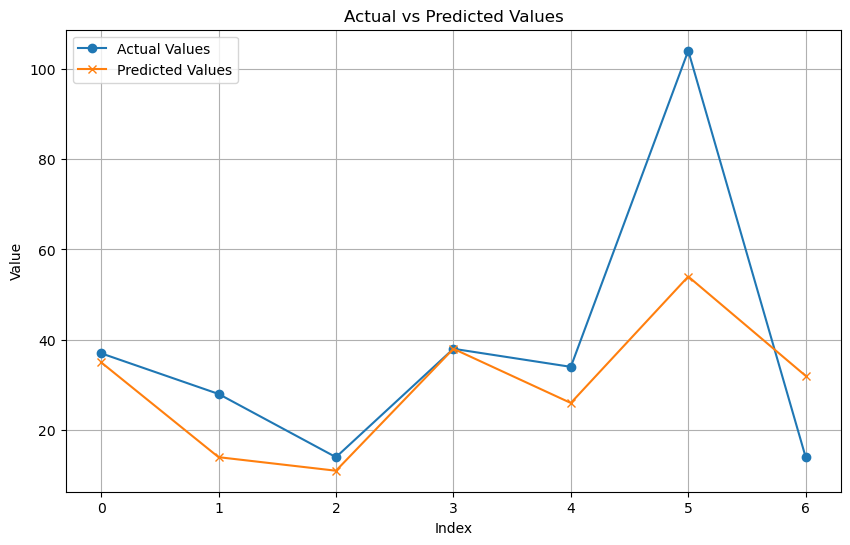

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Mendapatkan hasil prediksi untuk data uji
predictions = test_results.select("2021", "prediction").toPandas()
# Mengatasi nilai null dengan menghapus baris yang mengandung null
data = data.na.drop()

# Pemilihan fitur
feature_cols = data.columns[1:-1]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# ... (sisa kode tetap sama)


# Mengambil nilai sebenarnya dan prediksi
actual_values = predictions["2021"]
predicted_values = predictions["prediction"]

# Membuat array indeks untuk plotting
indices = np.arange(len(actual_values))

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(indices, actual_values, label='Actual Values', marker='o')
plt.plot(indices, predicted_values, label='Predicted Values', marker='x')

# Menambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
